In [ ]:
!python --version

Python 3.7.13


In [ ]:
!pip install -U pip
!pip install git+https://github.com/Music-and-Culture-Technology-Lab/omnizart
!omnizart download-checkpoints
!apt install fluidsynth
!pip install pyfluidsynth
!curl -L https://github.com/yt-dlp/yt-dlp/releases/latest/download/yt-dlp -o /usr/local/bin/yt-dlp
!chmod a+rx /usr/local/bin/yt-dlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Music-and-Culture-Technology-Lab/omnizart to /tmp/pip-req-build-f3ana5_5
  Running command git clone --filter=blob:none --quiet https://github.com/Music-and-Culture-Technology-Lab/omnizart /tmp/pip-req-build-f3ana5_5
  Resolved https://github.com/Music-and-Culture-Technology-Lab/omnizart to commit 70ce77f1a7f5b781f93d5c3f755d1c3fdfb40e90
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Output path: /usr/local/lib/python3.7/dist-packages/omnizart/checkpoints/chord/chord_v1/variables/variables.data-00000-of-00001
Total size: 42.19MB
Progress: 100%, 42.19MB, 1.22MB/s
Output path: /usr/local/lib/python3.7/dist-packages/omnizart/checkpoints/drum/drum_keras/variables/variables.data-00

After installing all necessary packages, 
provide a youtube link to apply AMT on and specify which transcription you want to use. The AMT system gives back a midi file which can be synthesized afterwards.

An example: https://www.youtube.com/watch?v=OyUJnV2R-5g 

Enter your YouTube link: https://www.youtube.com/watch?v=OyUJnV2R-5g


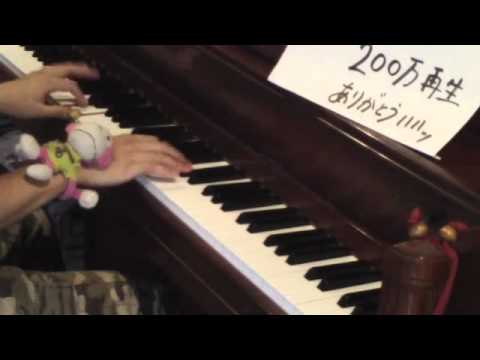

Downloading...
[youtube] OyUJnV2R-5g: Downloading webpage
[youtube] OyUJnV2R-5g: Downloading android player API JSON
[info] OyUJnV2R-5g: Downloading 1 format(s): 251
[download] Destination: 「ナイト・オブ・ナイツ」を弾き直してみたんですが... [OyUJnV2R-5g].webm
[download] 100% of 4.46MiB in 00:00
[ExtractAudio] Destination: 「ナイト・オブ・ナイツ」を弾き直してみたんですが... [OyUJnV2R-5g].mp3
Deleting original file 「ナイト・オブ・ナイツ」を弾き直してみたんですが... [OyUJnV2R-5g].webm (pass -k to keep)
Finished: 「ナイト・オブ・ナイツ」を弾き直してみたんですが... [OyUJnV2R-5g]


In [ ]:
# Download the youtube link you want to use
import os
# from google.colab import files
from IPython import display as dsp

url = input("Enter your YouTube link: ")

try:
  id = url.split("watch?v=")[1].split("&")[0]
  vid = dsp.YouTubeVideo(id)
  dsp.display(vid)
except Exception:
  pass

print("Downloading...")

!yt-dlp -x --audio-format mp3 --no-playlist "$url"
!yt-dlp --get-filename --no-playlist "$url" > tmp

uploaded_audio = os.path.splitext(open("tmp").readline().strip())[0]
!ffmpeg -i "$uploaded_audio".mp3 "$uploaded_audio".wav &> /dev/null

print(f"Finished: {uploaded_audio}")

dsp.Audio(f'''/content/{uploaded_audio}.mp3''')

In [ ]:
# Available modes for transcription 
transcription_modes = ["music-piano", "music-piano-v2", "music-assemble", "chord", "drum", "vocal", "vocal-contour", "beat"]
mode = input("Choose one transcription mode: " + str(transcription_modes)) or "music-assemble"
print("Chosen transcription mode: " + mode)

Choose transcription mode: ['music-piano', 'music-piano-v2', 'music-assemble', 'chord', 'drum', 'vocal', 'vocal-contour', 'beat']music-assemble


In [ ]:
# AMT
mode = mode
model = ""
if mode.startswith("music"):
  mode_list = mode.split("-")
  mode = mode_list[0]
  model = "-".join(mode_list[1:])


from omnizart.music import app as mapp
from omnizart.chord import app as capp
from omnizart.drum import app as dapp
from omnizart.vocal import app as vapp
from omnizart.vocal_contour import app as vcapp
from omnizart.beat import app as bapp

app = {
    "music": mapp,
    "chord": capp,
    "drum": dapp,
    "vocal": vapp,
    "vocal-contour": vcapp,
    "beat": bapp
}[mode]

model_path = {
    "piano": "Piano",
    "piano-v2": "PianoV2",
    "assemble": "Stream",
    "pop-song": "Pop",
    "": None
}[model]

midi = app.transcribe(f"{uploaded_audio}.wav", model_path=model_path)
midi.write(mode + model + ".mid")

2022-05-23 13:59:18 Loading model...
2022-05-23 13:59:18 Using built-in model /usr/local/lib/python3.7/dist-packages/omnizart/checkpoints/music/music_piano for transcription.


2022-05-23 13:59:30 Extracting feature...
2022-05-23 14:01:28 Predicting...


2022-05-23 14:02:31 Infering notes....


2022-05-23 14:02:37 MIDI file has been written to ./Regina Spektor- Après Moi (Studio Version) [QbeHq1CLqJ8].mid.
2022-05-23 14:02:37 Transcription finished


In [ ]:
# Synthesize the midi 
import scipy.io.wavfile as wave
from omnizart.remote import download_large_file_from_google_drive

SF2_FILE = "general_soundfont.sf2"
if not os.path.exists(SF2_FILE):
  print("Downloading soundfont...")
  download_large_file_from_google_drive(
      "16RM-dWKcNtjpBoo7DFSONpplPEg5ruvO",
      file_length=31277462,
      save_name=SF2_FILE
    )

if mode == "vocal-contour":
  os.rename(f"{uploaded_audio}_trans.wav", f"{uploaded_audio}_synth.wav")
else:
  print("Synthesizing MIDI...")
  out_name = f"{uploaded_audio}_synth.wav"
  raw_wav = midi.fluidsynth(fs=44100, sf2_path=SF2_FILE)
  wave.write(out_name, 44100, raw_wav)

!ffmpeg -i "$out_name" "tmp_synth.mp3" &>/dev/null
!mv tmp_synth.mp3 "$uploaded_audio"_synth.mp3

out_name = out_name.replace(".wav", ".mp3")
print(f"Finished: {out_name}")
dsp.Audio(out_name)

Output path: ./general_soundfont.sf2
Total size: 29.83MB
Progress: 100%, 29.83MB, 913.41KB/s
Synthesizing MIDI...
Finished: 「ナイト・オブ・ナイツ」を弾き直してみたんですが... [OyUJnV2R-5g]_synth.mp3
